In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [94]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [95]:
batch_size = 20

In [96]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [97]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

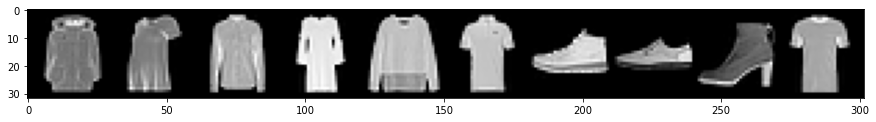

In [98]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images[:10], nrow=10))
plt.show()

In [99]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [100]:
device

'cuda'

## Model parameters

In [101]:
class VAE(nn.Module):
    def __init__(self, hidden_dim):
        super(VAE, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(784,392),
                                     nn.ReLU())
        
        self.hidden_mu = nn.Linear(392, self.hidden_dim)
        self.hidden_log_var = nn.Linear(392, self.hidden_dim)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 392),
                                     nn.ReLU(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output

In [102]:
hidden_dim = 64
net = VAE(hidden_dim)
optimizer = torch.optim.Adam(params = net.parameters())
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)
history = {'train':[], 'test':[]}

PATH = "pretrained/simple_vae.pth"
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history['train'] = checkpoint['train_loss']
history['test'] = checkpoint['test_loss']

net.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
  )
  (hidden_mu): Linear(in_features=392, out_features=64, bias=True)
  (hidden_log_var): Linear(in_features=392, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

## Training and testing

In [103]:
def loss_fn(mu, log_var, x_out, x):
    kl_loss = -0.5 * torch.sum( 1 + log_var - mu**2 - torch.exp(log_var))
    recon_loss = F.binary_cross_entropy(x_out, x.view(-1, 784), reduction='sum')
    loss = recon_loss + kl_loss
    return loss

In [104]:
# def train(epoch):
#     net.train()
#     running_loss = 0
#     for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):
#         optimizer.zero_grad()
#         mu, log_var, x_out = net(data)
#         loss = loss_fn(mu, log_var, x_out, data)
#         loss.backward()
#         running_loss += loss.item()
#         optimizer.step()
#         if batch_idx % (log_interval*6) == 0:
#             history['train'].append(loss.item()/len(data))
#     print("===> Epoch: {}/{} Average train loss: {:.4f}".format(epoch, num_epochs, running_loss/len(trainloader.dataset)))
    
# def test(epoch):
#     net.eval()
#     running_loss = 0
#     for batch_idx, (data, _) in enumerate(testloader):
#         with torch.no_grad():
#             mu, log_var, x_out = net(data)
#             loss = loss_fn(mu, log_var, x_out, data)
#             running_loss += loss.item()
#             if batch_idx % log_interval == 0:
#                 history['test'].append(loss.item()/len(data))
#     print("===> Test set loss: {:.4f}".format(running_loss/len(testloader.dataset)))

# if __name__ == "__main__":
#     num_epochs = 13
#     log_interval = 50
#     history = {'train':[], 'test':[]}
#     for epoch in range(1, num_epochs+1):
#         train(epoch)
#         test(epoch)
#         with torch.no_grad():
#             sample = torch.randn(64, hidden_dim) # 'output' of the bottleneck
#             sample = net.decode(sample)
#             save_image(sample.view(64, 1, 28, 28), 'results/sample_' + str(epoch) + '.png')

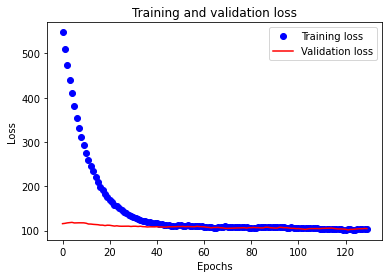

In [105]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_losses(history):
#     plt.clf()
    loss_values = smooth_curve(history['train'])
    val_loss_values = smooth_curve(history['test'])
    epochs = np.arange(len(loss_values))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(history)

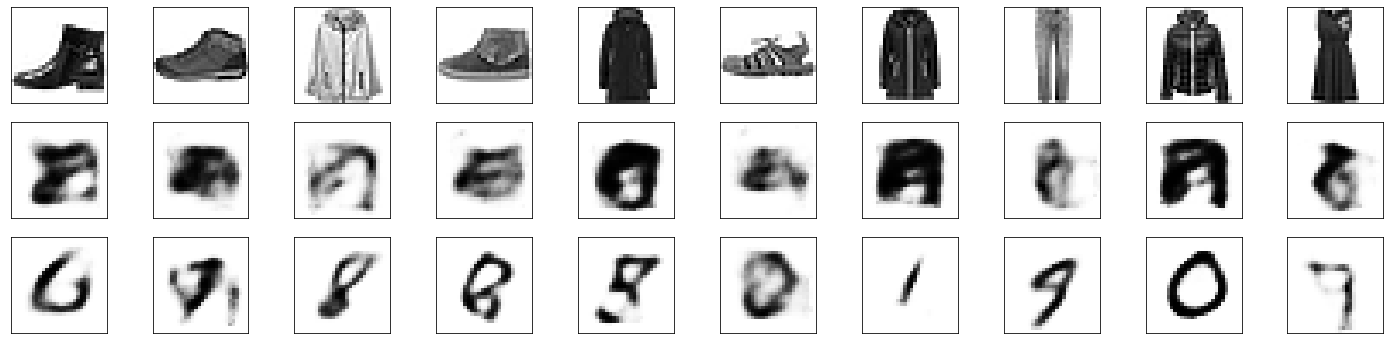

In [106]:
def example10(model, dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()

    images_flatten = images.view(images.size(0), -1)
    _, __, recon = model(images_flatten)
    sample = torch.randn(10, model.hidden_dim)
    gen = model.decode(sample)

    images = 255 - images.numpy()[:10]
    recon = 255 - recon.view(batch_size, 1, 28, 28).detach().numpy()[:10]
    gen = 255 - gen.view(10, 1, 28, 28).detach().numpy()

    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,6))

    for images, row in zip([images, recon, gen], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
example10(net, testloader)

## Saving new parameters

In [107]:
# torch.save({
#             'epoch': num_epochs,
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': history['train'],
#             'test_loss': history['test'],
#             }, PATH)

## MCMC

In [108]:
device='cpu'

In [109]:
class VAE_MCMC(nn.Module): # TODO: new architecture + HMC + no optimizer
    def __init__(self, hidden_dim):
        super(VAE_MCMC, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(784,196),
                                     nn.Softplus())
#                                      nn.Linear(392, 196))
#                                      nn.Softplus())
        
        self.hidden_mu = nn.Linear(196, self.hidden_dim)
        self.hidden_log_var = nn.Linear(196, self.hidden_dim)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 196),
                                     nn.Softplus(),
                                     nn.Linear(196, 392),
                                     nn.Softplus(),
                                     nn.Linear(392, 784),
                                     nn.Sigmoid())

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std) # get normal distribution size of sigma
        return mu + z*std
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output

In [110]:
def std_normal(mu=None, std=None, dim=784):
    loc = mu if mu!=None else torch.zeros(dim, device=device, requires_grad=False)
    scale = std if std!=None else torch.ones(dim, device=device, requires_grad=False)
    std_normal = torch.distributions.Normal(loc=loc, scale=scale)
    return std_normal

In [111]:
def log_prob_density(x_out, x):
    loss = F.binary_cross_entropy(x_out, x.view(-1, 784), reduction='none')
    return loss # vector

In [138]:
def HMC(x_out, current_z, x, epsilon, L): # U(z) = -logp(z,x)
    z = current_z
    r = torch.randn_like(z)
    current_r = r
    U = torch.sum(log_prob_density(net2.decode(z), x).sum(1) - std_normal(dim=z.shape[1]).log_prob(z).sum(1))
#     U = U.mean(dim=1)
#     Ulist = []
#     inputs = []
#     for j in range(len(U)):
#         Ulist.append(U[j])
#         inputs.append(x_out[j])
#         inputs.append(z[j])
    
    for i in range(L):
#         U = torch.sum(log_prob_density(net2.decode(z), x).sum(1) - std_normal(dim=z.shape[1]).log_prob(z).sum(1))
        r = r + 0.5 * epsilon * torch.autograd.grad(U, z, retain_graph=True)[0]
        z = z + epsilon * r
        print("Has NaN = {}".format(torch.isnan(net2.decode(z)).sum()))
        U = torch.sum(log_prob_density(net2.decode(z), x).sum(1) - std_normal(dim=z.shape[1]).log_prob(z).sum(1))
        r = r + 0.5 * epsilon * torch.autograd.grad(U, z, retain_graph=True)[0]
#         print("{} leapfrog step, U = {}".format(i, U))
                                
    current_U = log_prob_density(net2.decode(current_z), x).sum(1) +\
                std_normal(dim=current_z.shape[1]).log_prob(current_z).sum(1)
    current_K = ((current_r**2) / 2).sum(1)
    proposed_U = log_prob_density(net2.decode(z), x).sum(1) +\
                 std_normal(dim=z.shape[1]).log_prob(z).sum(1)
    proposed_K = ((r**2) / 2).sum(1)
    
    # Metropolis
    u = D.uniform.Uniform(0,1).sample_n(batch_size)
    zfilter = torch.ones(batch_size,1, device=device)
    for i in range(batch_size):
        if u[i] > torch.exp(current_U-proposed_U+current_K-proposed_K)[i]:
            zfilter[i] = 0.0
    result = zfilter * z + (1-zfilter) * current_z
    return result        

In [139]:
def train(epoch, epsilon):
    torch.autograd.set_detect_anomaly(True)
    net2.train()
    running_loss = 0
    L = int(torch.linalg.norm(epsilon).item()) # leapfrog steps for HMC
    for batch_idx, (data, _) in enumerate(tqdm_notebook(trainloader)):       
        mu, log_var, x_out = net2(data)
             
        epsilon = epsilon * torch.exp(log_var)
        z = net2.reparametrize(mu, log_var)

        loss = loss_fn(mu, log_var, x_out, data)
        loss.backward(retain_graph=True)

        with torch.no_grad():
            for l in [net2.decoder, net2.hidden_mu, net2.hidden_log_var]:
                if hasattr(l, 'weight'):
                    l.weight.grad = None
                    l.bias.grad = None
#             for l in [net2.encoder, net2.hidden_mu, net2.hidden_log_var]:
#                 if hasattr(l, 'weight'):  # optimizer step
#                     l.weight -= l.weight.grad*lr
#                     l.bias -= l.bias.grad*lr
#                     l.weight.grad.zero_()
#                     l.bias.grad.zero_()
        optimizer.step()
        optimizer.zero_grad()
    
        for m in range(M):
            print("{}/{} HMC iteration".format(m+1,M))
            z = HMC(x_out, z, data, epsilon, L)
        
        loss = loss_fn(mu, log_var, net2.decode(z), data)
        loss.backward(retain_graph=True)
        
        with torch.no_grad():
            for l in [net2.encoder, net2.hidden_mu, net2.hidden_log_var]:
                if hasattr(l, 'weight'):
                    l.weight.grad = None
                    l.bias.grad = None
#             for l in [net2.decoder]:#, net2.hidden_mu, net2.hidden_log_var]:
#                 if hasattr(l, 'weight'):
#                     l.weight -= l.weight.grad*lr
#                     l.bias -= l.bias.grad*lr
#                     l.weight.grad.zero_()
#                     l.bias.grad.zero_()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        if batch_idx % (log_interval*6) == 0: history['train'].append(loss.item()/len(data))
                         
    print("===> Epoch: {}/{} Average train loss: {:.4f}".format(epoch, num_epochs, running_loss/len(trainloader.dataset)))
    
def test(epoch):
    net2.eval()
    running_loss = 0
    for batch_idx, (data, _) in enumerate(testloader):
        with torch.no_grad():
            mu, log_var, x_out = net2(data)
            loss = loss_fn(mu, log_var, x_out, data)
            running_loss += loss.item()
            if batch_idx % log_interval == 0:
                history['test'].append(loss.item()/len(data))
    print("===> Test set loss: {:.4f}".format(running_loss/len(testloader.dataset)))

if __name__ == "__main__":
    hidden_dim = 48
    net2 = VAE_MCMC(hidden_dim)
    optimizer = torch.optim.Adam(net2.parameters())
    num_epochs = 5
    log_interval = 50
    history = {'train':[], 'test':[]}
    epsilon = torch.ones(hidden_dim)
    lr=0.001
    M=10
    for epoch in range(1, num_epochs+1):
        train(epoch,epsilon)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, hidden_dim) # 'output' of the bottleneck
            sample = net2.decode(sample)
            save_image(sample.view(64, 1, 28, 28), 'results/sample_mcmc_' + str(epoch) + '.png')

  0%|          | 0/3000 [00:00<?, ?it/s]

1/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
2/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
3/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
4/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
5/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
6/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
7/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
8/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
9/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
10/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
1/10 HMC iteration
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 0
Has NaN = 

RuntimeError: all elements of input should be between 0 and 1

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

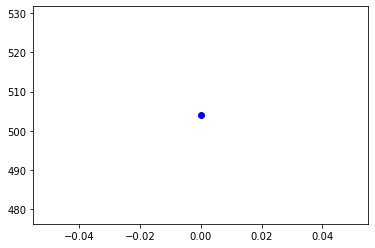

In [140]:
plot_losses(history)

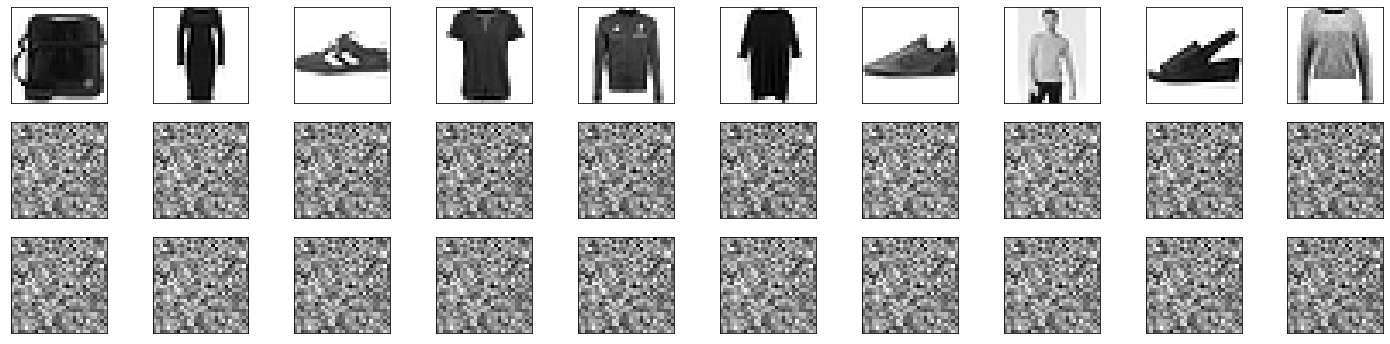

In [122]:
example10(net2, testloader)

In [274]:
a = torch.randn(784,requires_grad=True)
b = torch.randn(784,requires_grad=True)
c = torch.randn(1,requires_grad=True)

i = [torch.autograd.grad(t, inputs=[a,a], allow_unused=True) for t in [c,c]]

In [275]:
i

[(None, None), (None, None)]

In [51]:
t = (342,24,2,235)


In [53]:
t[0]

342

In [ ]:
9.5**0.1

In [87]:
nn.Softplus(torch.randn(2))

Softplus(beta=tensor([-0.2323, -1.1006]), threshold=20)

In [135]:
t=torch.Tensor([2423,3435,np.nan])
nn.Softplus(t)

Softplus(beta=tensor([2423., 3435.,   nan]), threshold=20)

In [136]:
5.6897e-03

0.0056897

In [137]:
torch.isnan(t).sum()

tensor(1)